In [1]:
# %load_ext autoreload
# %autoreload 2

import matplotlib.pyplot as plt
# %matplotlib widget

import pandas as pd
pd.set_option("display.max_rows", None)

import numpy as np 
import seaborn as sns
import datetime as dt

In [2]:
data = pd.read_csv("./at_home_test_data_study_centers_201909.csv.csv")

# Converting object type to datetime
data["device_local_date"] = pd.to_datetime(data["device_local_date"])
# Shortening shopping center name (to make plotting easier)
data["shopping_center_id"] = data.apply(lambda x: x["shopping_center_id"][:8], axis=1)

data.head()

,shopping_center_id,device_local_date,device_hash_id
0,b43e9e4f,2019-09-14 10:00:25,6fdffac307
1,b43e9e4f,2019-09-14 17:13:15,386141ebd8
2,b43e9e4f,2019-09-14 09:07:06,b06242b848
3,b43e9e4f,2019-09-14 17:14:49,c13cc52e82
4,599cb959,2019-09-14 10:17:35,f339ddf999


# Data Exploration

In [3]:
data.describe()

<ipython-input-3-2bb0b18689d4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,shopping_center_id,device_local_date,device_hash_id
count,81838,81838,81838
unique,4,74167,5702
top,599cb959,2019-09-14 11:14:39,c0d915dfc1
freq,39827,5,2292
first,NaN,2019-09-01 00:19:53,NaN
last,NaN,2019-09-17 23:59:59,NaN


Conclusion:
- No missing values(81 838 in each column)
- 4 shopping center
- 5702 client

## Dataset size

### By shopping center

In [4]:
count_by_center = data.groupby("shopping_center_id").count()
count_by_center

,device_local_date,device_hash_id
shopping_center_id,,
0cd35523,11292,11292
599cb959,39827,39827
b43e9e4f,15080,15080
cb2d5bb6,15639,15639


In [5]:
unique_by_center = data.groupby("shopping_center_id").nunique()
unique_by_center

,device_local_date,device_hash_id
shopping_center_id,,
0cd35523,10639,1077
599cb959,37181,2417
b43e9e4f,14459,1024
cb2d5bb6,14659,1334


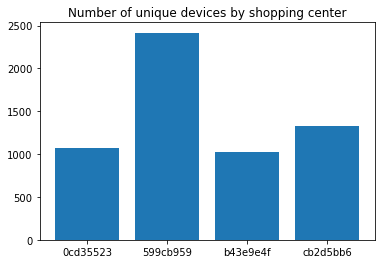

In [6]:
plt.bar(count_by_center.index, unique_by_center["device_hash_id"])
plt.title("Number of unique devices by shopping center")
plt.show()

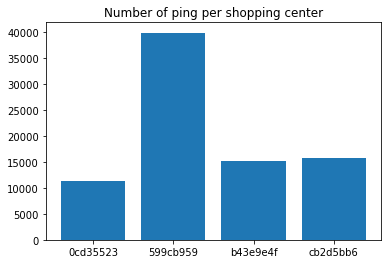

In [7]:
plt.bar(count_by_center.index, count_by_center["device_local_date"], align='center')
plt.title("Number of ping per shopping center")
plt.show()

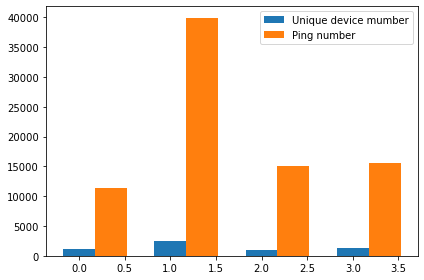

In [8]:
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(count_by_center))

device_nbr_plot = ax.bar(index, unique_by_center["device_hash_id"], bar_width, label="Unique device mumber")
ping_nbr_plot = ax.bar(index + bar_width, count_by_center["device_local_date"], bar_width, label="Ping number")

ax.legend()
fig.tight_layout()
plt.show()

Conclusion
- One of the commercial center (`599cb959-...`) has 2 times more unique client and around 4 times more pings than the 3 other

### In time

In [9]:
print("first date: ", data["device_local_date"].min())
print("last date: ", data["device_local_date"].max())
print("range: ", data["device_local_date"].max() - data["device_local_date"].min())

first date:  2019-09-01 00:19:53
last date:  2019-09-17 23:59:59
range:  16 days 23:40:06


Conclusion:

- 17 days of data (from 1 to 17 september 2019 (included))
- 2 full weeks plus one sunday, one monday and one thursday

### By device

In [10]:
count_by_device = data.groupby("device_hash_id").count()
count_by_device["device_local_date"].describe()

count    5702.000000
mean       14.352508
std        54.092743
min         1.000000
25%         2.000000
50%         5.000000
75%        12.000000
max      2292.000000
Name: device_local_date, dtype: float64

Conclusion:
- Each device has pinged 5 times in general (median)
- One device has pinged more than 2000 times, it's weird. Maybe a device always at the shopping center ? Or someone who work there ?

    => I need to investigate these outliers

## Duplicate pings

In [11]:
unique_by_device = data.groupby("device_hash_id").nunique()
unique_by_device["device_local_date"].describe()

count    5702.000000
mean       13.757980
std        53.250936
min         1.000000
25%         2.000000
50%         5.000000
75%        12.000000
max      2292.000000
Name: device_local_date, dtype: float64

In [12]:
print("Sum of all ping time:", count_by_device["device_local_date"].sum())
print("Sum of unique ping time by device:", unique_by_device["device_local_date"].sum())

Sum of all ping time: 81838
Sum of unique ping time by device: 78448


Conclusion:
- The sum is different: somme device ping multiple time at the same time ? Or ping 2 detector at the same time ?
  
  => Maybe I should remove the duplicates ?

In [13]:
# One duplicate exemple
data[(data["device_hash_id"] == "296f6e87f5") & (data["device_local_date"] == dt.datetime.fromisoformat("2019-09-02 09:12:25"))]

,shopping_center_id,device_local_date,device_hash_id
114,599cb959,2019-09-02 09:12:25,296f6e87f5
119,599cb959,2019-09-02 09:12:25,296f6e87f5


In [14]:
data.duplicated().sum()

3390

In [15]:
assert count_by_device["device_local_date"].sum() - data.duplicated().sum() == unique_by_device["device_local_date"].sum()

Conclusion:
- There is 3390 perfect duplicate
  
  => I should remove them

In [16]:
print("before", len(data.index))

# REMOVING DUPLICATES
duplicate = data[data.duplicated()]
data = data.drop_duplicates()

print("after", len(data.index))

before 81838
after 78448


In [17]:
duplicate.groupby("shopping_center_id").count()

,device_local_date,device_hash_id
shopping_center_id,,
0cd35523,567,567
599cb959,1509,1509
b43e9e4f,482,482
cb2d5bb6,832,832


In [18]:
# Does one center has more duplicate ?

data_by_center = data.groupby("shopping_center_id")
duplicate_by_center = duplicate.groupby("shopping_center_id")

df_data = {"center_name": [], "unique_ping": [], "duplicate_ping": [], "percentage_duplicate": []}
for center_name in data["shopping_center_id"].unique():
    df_data["center_name"].append(center_name)
    df_data["unique_ping"].append(len(data_by_center.get_group(center_name).index))
    df_data["duplicate_ping"].append(len(duplicate_by_center.get_group(center_name).index))
    df_data["percentage_duplicate"].append(df_data["duplicate_ping"][-1] / (df_data["unique_ping"][-1] + df_data["duplicate_ping"][-1]) * 100)

duplicate_proportion = pd.DataFrame(df_data)
duplicate_proportion

,center_name,unique_ping,duplicate_ping,percentage_duplicate
0,b43e9e4f,14598,482,3.196286
1,599cb959,38318,1509,3.788887
2,0cd35523,10725,567,5.021254
3,cb2d5bb6,14807,832,5.320033


Conclusion:
- There is between 3 to 5% of duplicated ping in each shopping center. It's not a problem specific to one shopping center.

## First time repartition

In [19]:
data["ping_hour"] = data["device_local_date"].dt.hour
data["ping_weekday"] = data["device_local_date"].dt.weekday
data.head(3)

,shopping_center_id,device_local_date,device_hash_id,ping_hour,ping_weekday
0,b43e9e4f,2019-09-14 10:00:25,6fdffac307,10,5
1,b43e9e4f,2019-09-14 17:13:15,386141ebd8,17,5
2,b43e9e4f,2019-09-14 09:07:06,b06242b848,9,5


In [20]:
def plot_ping_in_time(df):
    grid = sns.FacetGrid(df, row="shopping_center_id", col="ping_weekday", margin_titles=True)
    grid.map(sns.histplot, "ping_hour", binwidth=1, binrange=(0, 24))
    return grid

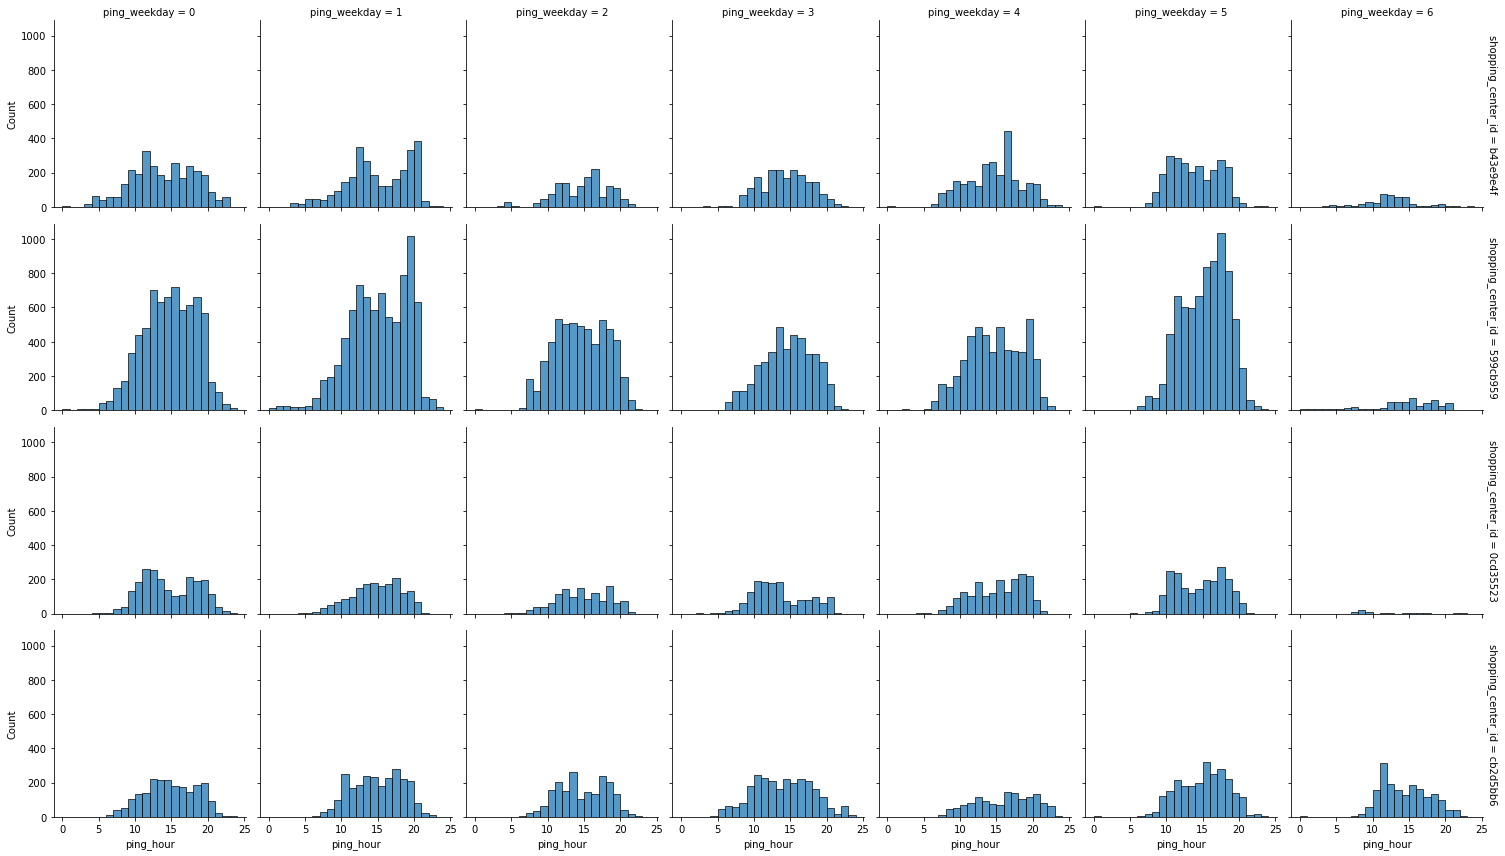

In [21]:
plot_ping_in_time(data)
plt.show()

Conclusion:
- We have data for each day of the weak, for each shopping center
- Aside for `0cd35523` the sunday, maybe it's closed ?
- The first 3 shopping center have less visit the sunday (are they closed ?)
- The 4th one (`cb2d5bb6`) doesn't have this. He must be openned every day, including sunday

## Searching for outliers devices (ones that ping a lot)

### Number of ping by device reparition, in all data

In [22]:
count_by_device = data.groupby("device_hash_id").count()

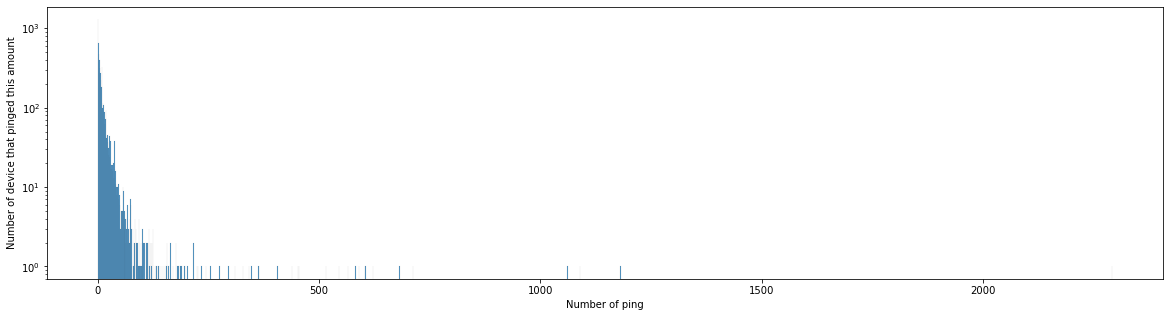

In [23]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.histplot(count_by_device["device_local_date"], binrange=(0, 2292), ax=ax)
ax.set(xlabel="Number of ping", ylabel="Number of device that pinged this amount")
ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

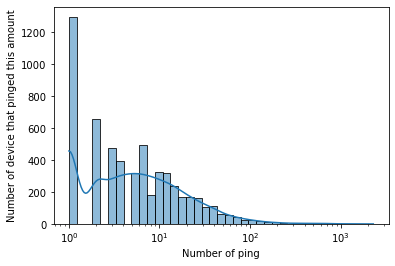

In [24]:
ax = sns.histplot(count_by_device["device_local_date"], kde=True, log_scale=True)
ax.set(xlabel="Number of ping", ylabel="Number of device that pinged this amount")
plt.show()

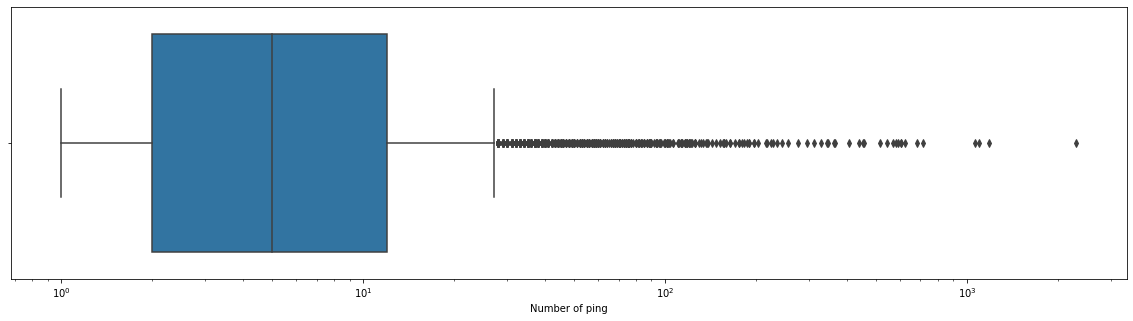

In [25]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(x=count_by_device["device_local_date"], ax=ax)
ax.set(xlabel="Number of ping")
ax.set_xscale('log')
plt.show()

Conclusion:

- Majority of device in the dataset pinged between 1 and 10 times (~4000 devices)
- Some devices pinged between 10 and 100 times (~2000 devices)

=> Some devices must be comming multiple days and pinging more. I need to check ping by day number to get real outliers

### Number of ping by device reparition, in one day

In [26]:
data["ping_day"] = data["device_local_date"].dt.day
data.head(3)

,shopping_center_id,device_local_date,device_hash_id,ping_hour,ping_weekday,ping_day
0,b43e9e4f,2019-09-14 10:00:25,6fdffac307,10,5,14
1,b43e9e4f,2019-09-14 17:13:15,386141ebd8,17,5,14
2,b43e9e4f,2019-09-14 09:07:06,b06242b848,9,5,14


In [27]:
meaned_ping_by_day_by_device = data.groupby(by=["device_hash_id", "ping_day"], as_index=False).count().groupby(by=["device_hash_id"]).mean()["device_local_date"]
meaned_ping_by_day_by_device.describe()

count    5702.000000
mean        7.781121
std        16.695411
min         1.000000
25%         1.500000
50%         3.666667
75%         8.000000
max       622.000000
Name: device_local_date, dtype: float64

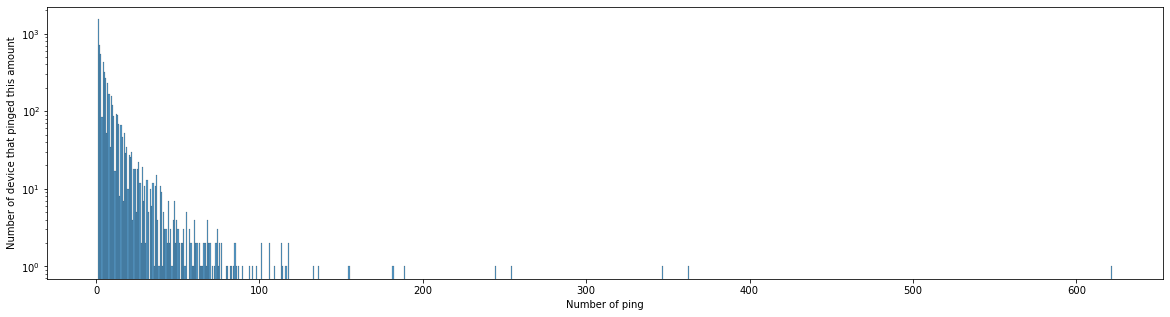

In [28]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.histplot(meaned_ping_by_day_by_device, ax=ax)
ax.set(xlabel="Number of ping", ylabel="Number of device that pinged this amount")
ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

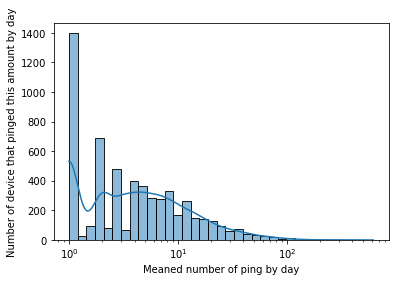

In [29]:
ax = sns.histplot(meaned_ping_by_day_by_device, kde=True, log_scale=True)
ax.set(xlabel="Meaned number of ping by day", ylabel="Number of device that pinged this amount by day")
plt.show()

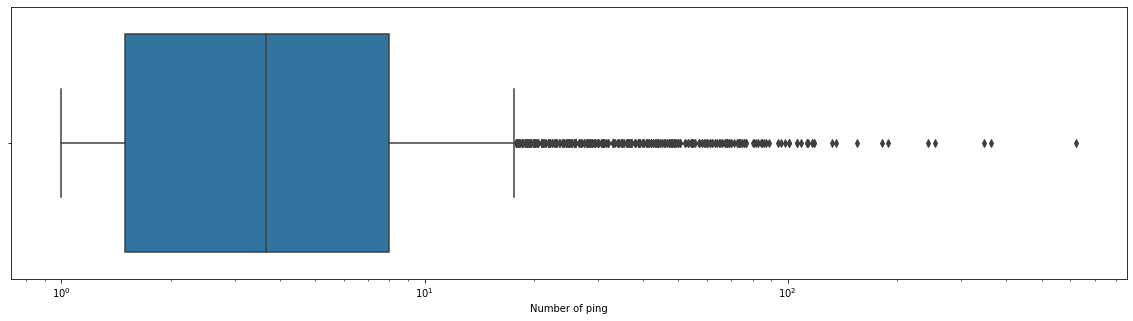

In [30]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(x=meaned_ping_by_day_by_device, ax=ax)
ax.set(xlabel="Number of ping")
ax.set_xscale('log')
plt.show()

Conclusion:

- Even by day, some devices ping way more than the others (over 100 ping in a day)

### Over 100 pinged by day

In [31]:
PING_LIMIT = 100

outliers_devices = meaned_ping_by_day_by_device[meaned_ping_by_day_by_device > PING_LIMIT].sort_values(ascending=False).index
outliers_devices

Index(['b2dd241bcc', '0f20ed1192', 'fa4acee13c', 'c0d915dfc1', 'c75717034a',
       'a7d0146fde', '5ebbcbd43e', 'e3d538fc31', 'c46f21e7bf', '96737a4da8',
       'cc65bafc80', 'c747eed40a', 'a80e18d995', '38d57c517f', 'af59285b12',
       '1c9ef07ca5', '8145b84bf3', 'ed1714b467', '0ecc70ac85', '3e7cacf4c8',
       'a1cb49c576'],
      dtype='object', name='device_hash_id')

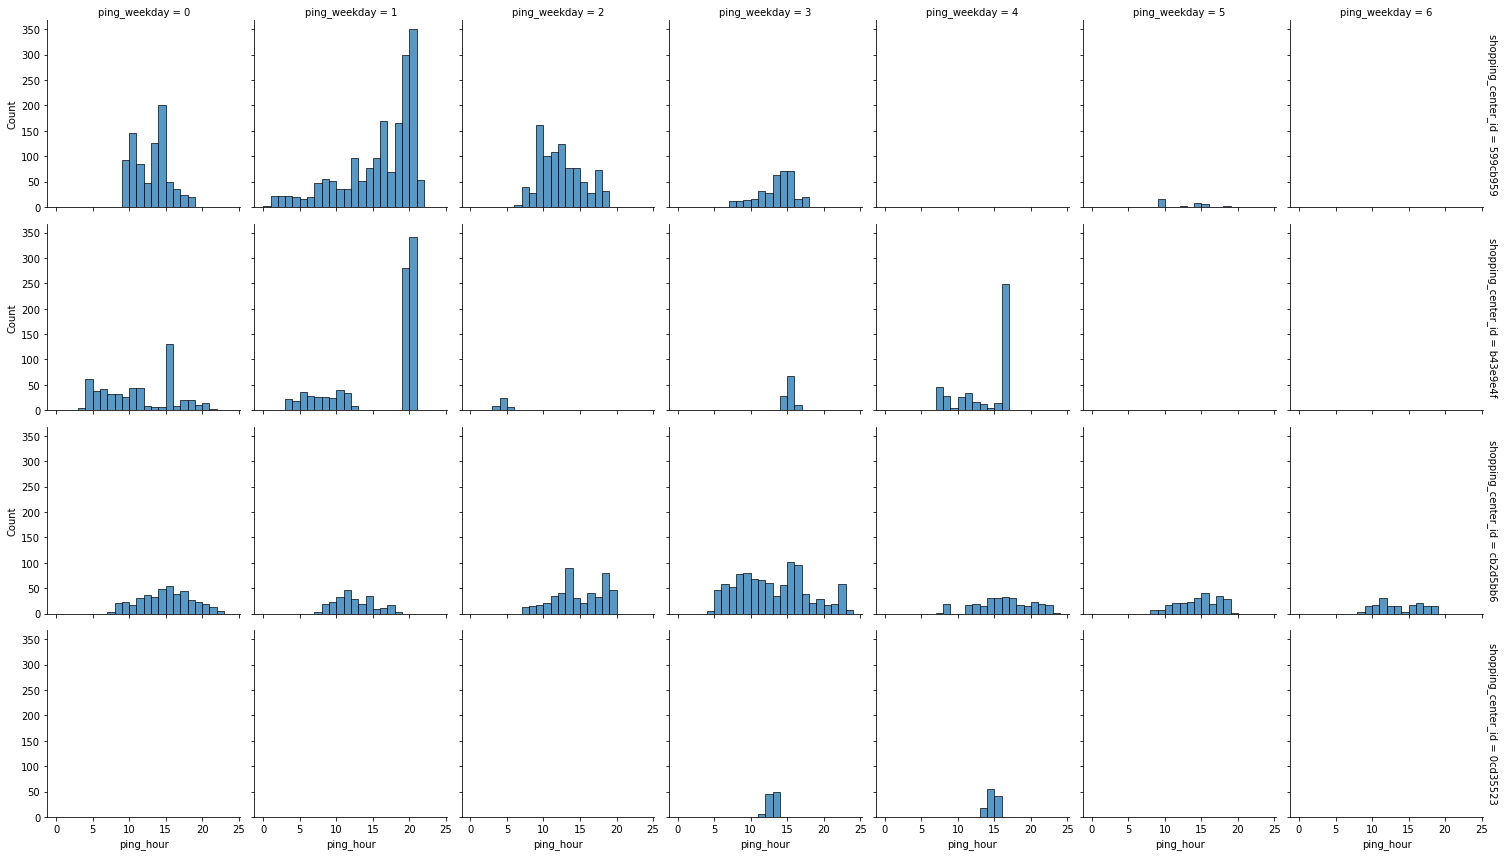

In [32]:
outliers_only = data[data["device_hash_id"].isin(outliers_devices)]
plot_ping_in_time(outliers_only)
plt.show()

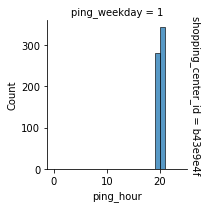

In [33]:
one_outlier = data[data["device_hash_id"] == outliers_devices[0]]
plot_ping_in_time(one_outlier)
plt.show()

In [34]:
one_outlier.sort_values(by="device_local_date", ascending=True).head(15)

,shopping_center_id,device_local_date,device_hash_id,ping_hour,ping_weekday,ping_day
31619,b43e9e4f,2019-09-17 19:35:01,b2dd241bcc,19,1,17
50440,b43e9e4f,2019-09-17 19:35:06,b2dd241bcc,19,1,17
25811,b43e9e4f,2019-09-17 19:35:11,b2dd241bcc,19,1,17
29794,b43e9e4f,2019-09-17 19:35:16,b2dd241bcc,19,1,17
25742,b43e9e4f,2019-09-17 19:35:21,b2dd241bcc,19,1,17
29440,b43e9e4f,2019-09-17 19:35:26,b2dd241bcc,19,1,17
46984,b43e9e4f,2019-09-17 19:35:31,b2dd241bcc,19,1,17
24029,b43e9e4f,2019-09-17 19:35:36,b2dd241bcc,19,1,17
28323,b43e9e4f,2019-09-17 19:35:41,b2dd241bcc,19,1,17
38,b43e9e4f,2019-09-17 19:35:46,b2dd241bcc,19,1,17


Conclusion:

- Device `b2dd241bcc` pinged every 5 seconds for ~1 hour
- I think this is not a normal behavior ?

=> I should study the ping frequency by day

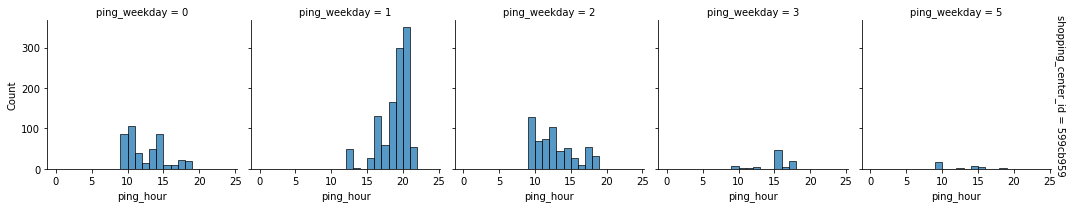

In [35]:
one_outlier = data[data["device_hash_id"] == outliers_devices[3]]
plot_ping_in_time(one_outlier)
plt.show()

Conclusion:

- I tihink Outliers are pinging a lot because of their ping frequency and not because it's a device always in the shopping center

=> I should get unique device number by slice of x minutes (30 ?)

## Unique device by slice

In [36]:
# Slice length in minute
slice_len = 30

data["slice_id"] = data["device_local_date"].apply(lambda t: (t.weekday() * 3600 + t.hour * 60 + t.minute) // slice_len)
data.sort_values(by="slice_id", ascending=True).head(10)

,shopping_center_id,device_local_date,device_hash_id,ping_hour,ping_weekday,ping_day,slice_id
27452,599cb959,2019-09-09 00:07:22,b106b982ef,0,0,9,0
28084,599cb959,2019-09-09 00:17:45,b106b982ef,0,0,9,0
43861,599cb959,2019-09-16 00:32:34,b106b982ef,0,0,16,1
26617,b43e9e4f,2019-09-09 00:45:05,160d8cc355,0,0,9,1
34064,599cb959,2019-09-16 00:51:58,db3b15425d,0,0,16,1
29715,b43e9e4f,2019-09-09 00:45:51,160d8cc355,0,0,9,1
60679,599cb959,2019-09-16 00:52:40,db3b15425d,0,0,16,1
28197,599cb959,2019-09-16 00:53:22,db3b15425d,0,0,16,1
43384,599cb959,2019-09-16 00:40:32,b106b982ef,0,0,16,1
42479,b43e9e4f,2019-09-09 00:43:17,160d8cc355,0,0,9,1


In [37]:
# One device per slice
unique_device_by_slice = data.drop_duplicates(subset=["shopping_center_id", "slice_id", "device_hash_id"])
unique_device_by_slice.sort_values(by="slice_id", ascending=True).head(10)

,shopping_center_id,device_local_date,device_hash_id,ping_hour,ping_weekday,ping_day,slice_id
27452,599cb959,2019-09-09 00:07:22,b106b982ef,0,0,9,0
43384,599cb959,2019-09-16 00:40:32,b106b982ef,0,0,16,1
26617,b43e9e4f,2019-09-09 00:45:05,160d8cc355,0,0,9,1
28197,599cb959,2019-09-16 00:53:22,db3b15425d,0,0,16,1
37187,599cb959,2019-09-02 02:18:50,e05686dece,2,0,2,4
122,599cb959,2019-09-02 02:38:48,e05686dece,2,0,2,5
63902,599cb959,2019-09-02 03:11:04,e05686dece,3,0,2,6
3913,b43e9e4f,2019-09-02 03:59:21,a1cb49c576,3,0,2,7
14809,b43e9e4f,2019-09-16 03:33:27,4d3b8306e8,3,0,16,7
179,599cb959,2019-09-02 03:31:05,e05686dece,3,0,2,7


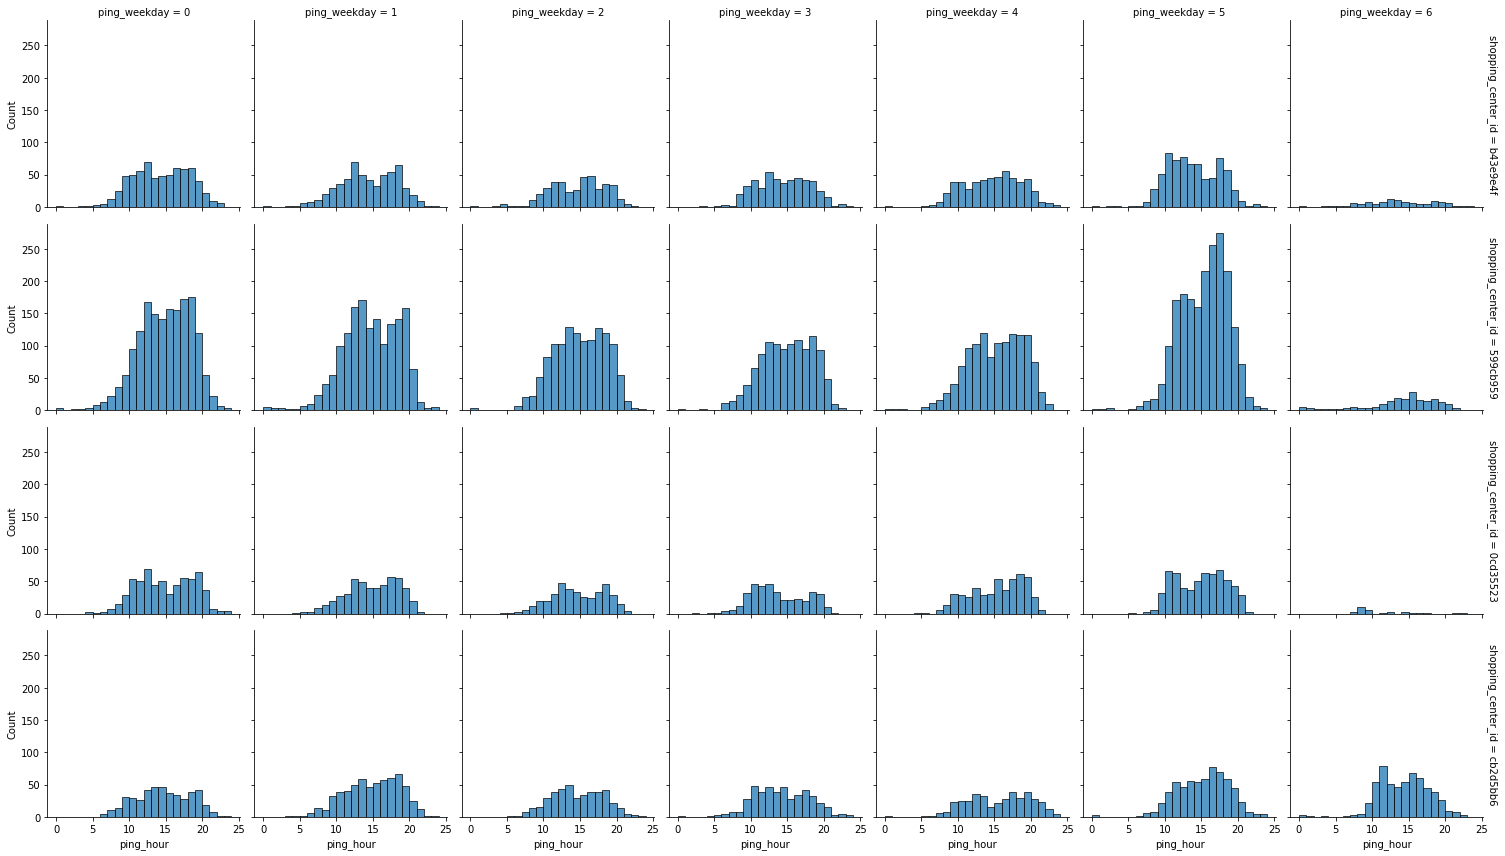

In [38]:
plot_ping_in_time(unique_device_by_slice)
# plt.title(f"Number of ping (with max 1 ping by device by slice of {slice_len} minutes")
plt.show()

Conclusion:

- I think that looks better than the first one. Some spikes have been removed
- The max number of ping in one hour is around 250 and not 1000